In [1]:
import TurbPy as tb
from TurbPy.imports import *

In [2]:
# deck = 'KH_Lv1di/'
# deck = 'KH_new/'
deck = 'KH_400ppc_200wci2/'
# deck = 'KH_beta0.1/'
# deck = 'turb2/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx_de = info['Lx/de']
ly_de = info['Ly/de']

lx_di = info['Lx/di']
ly_di = info['Ly/di']

nx = int(info['nx'])
ny = int(info['ny'])

lxr_di = np.linspace(0, lx_di, nx)
lyr_di = np.linspace(0, ly_di, ny)

In [3]:
# t = 5295
# ds = tb.load_vars(dirs, t, 'electron')

t = times[250]
ds = tb.load_vars(dirs, t, 'electron')

In [4]:
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])

dex = ds['ex'] - np.mean(ds['ex'])
dey = ds['ey'] - np.mean(ds['ey'])
dez = ds['ez'] - np.mean(ds['ez'])

In [5]:
def flip2D(var):
  var_flip = np.flip(var, axis = 0)
  
  var_per = np.concatenate((var, var_flip))
  return var_per

In [6]:
dsi = tb.load_vars(dirs, t, 'ion')
jz_per = flip2D(ds['jz'] + dsi['jz'])

In [7]:
dbx_flip = np.flip(dbx, axis = 0)
dbx_per = np.concatenate((dbx, dbx_flip))

dby_flip = np.flip(dby, axis = 0)
dby_per = np.concatenate((dby, dby_flip))

dbz_flip = np.flip(dbz, axis = 0)
dbz_per = np.concatenate((dbz, dbz_flip))


dex_flip = np.flip(dex, axis = 0)
dex_per = np.concatenate((dex, dex_flip))

dey_flip = np.flip(dey, axis = 0)
dey_per = np.concatenate((dey, dey_flip))

dez_flip = np.flip(dez, axis = 0)
dez_per = np.concatenate((dez, dez_flip))

dsi = tb.load_vars(dirs, t, 'ion')

# jz_flip = np.flip(ds['jz'] + dsi['jz'], axis = 0)
# jz_per = np.concatenate((ds['jz'] + dsi['jz'], jz_flip))

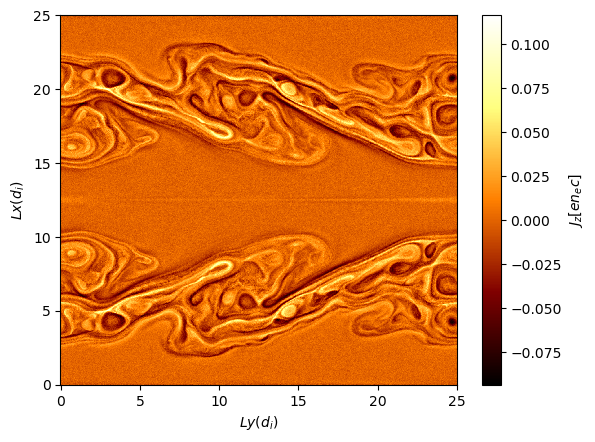

In [8]:
plt.pcolormesh(lyr_di, lyr_di, jz_per, cmap = 'afmhot')
plt.colorbar(label = r'$J_z \left[ e n_e c\right]$')
plt.ylabel(r'$Lx (d_i)$')
plt.xlabel(r'$Ly (d_i)$')
plt.savefig(figs + f'Jzp_{t}.jpg', dpi = 400)

In [9]:
# k, fft = tb.EnSpec2D(dbx, dby,  numbins = 10 * nx, lx = lx, ly = ly)
# k, fft = tb.EnSpec2D(dex_per, dey_per, dez_per, numbins = 15 * nx, lx = lx_de, ly = lx_de)\
k, fft = tb.EbSpec2D(dbx_per, dby_per)

In [10]:
x = np.linspace(10**(-1), 1, 100)
y = tb.powrl(x, 3 *10**(-8), a = -8/3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


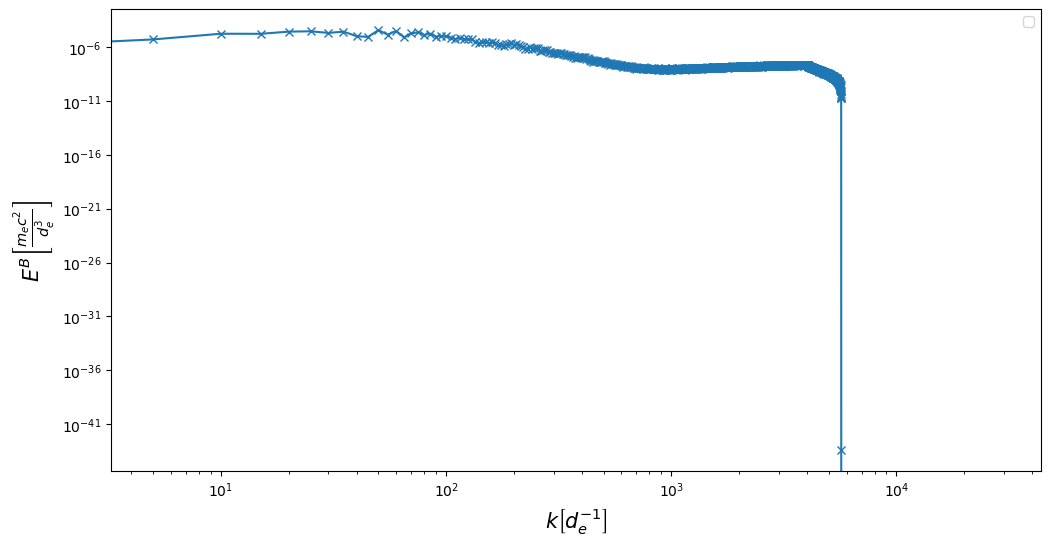

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize = (12, 6))
ax1.loglog(k, fft, marker = 'x')
# ax1.loglog(x,y, color = 'black', linestyle = '--',label = r'$k^{-8/3}$')
# ax1.set_ylim(10**(-9), 5 * 10**(-2))
# ax1.set_ylim(5 * 10**(-10), 5 * 10**(-4))
ax1.set_ylabel(r'$E^B \left[ \frac{m_e c^2}{d_e^3}  \right]$', size  = 15)
ax1.set_xlabel(r'$k  \left[ d_e^{-1}    \right]$', size = 15)
ax1.legend()
fig.savefig(figs + f'spect_{t}.jpg', dpi = 400)